# Galaxy Morphologies
Lab Assignment Six: Convolutional Network Architectures
<br /><br /><br />
***Richmond Aisabor***

# Business Understanding

To understand how the galaxies formed, researchers need to be able to classify them according to their shape. This dataset is a sample of the roughly one hundred billion galaxies in the observable universe. Each of these galaxies, containing billions of stars, has had a unique life and has interacted with it's environment in a different way. Through studying the morphology of galaxies, answers to how humans came to exist or the meaning of life become much clearer and easier to locate. In order to relate the different shapes of galaxies to the physical phenomenon that created them, such images must be classified. The overall goal is to understand the natural processes that created the universe by analyzing the formation of galaxies. 

To be confident that the algorithm is learning properly, it must have a success rate better than 50%, a random chance. The goal for the algorithm is to be as close to 100% accuracy as possible and the user that benefits most from a successful algorithm is an astronomer. To be considered a successful algorithm, it must have a success rate of atleast 90%.

The dataset is called the **Galaxy10** dataset. It contains 21,785 69x69 pixel colored images of galaxies and 10 distinct classes. Galaxy10 images were shot by The Sloan Digital Sky Survey (SDSS) and the classification labels were created by Galaxy Zoo.

Dataset source: https://astronn.readthedocs.io/en/latest/galaxy10.html

#### Measure of Performance

The Galaxy10 dataset is not a balanced dataset, yet we care about all 10 classes equally, so the best option for measuring performance is the F1-Score. The F1-Score is calculated from the recall and precision, where the precision is true positive results divided by all positive results, including those not identified correctly, and the recall is the true positive results divided by all samples that should have been identified as positive. F1-Score is advantageous for minimizing false positives and false negatives.

# Data Preperation

In [1]:
import os
import zipfile
import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from sklearn.utils import shuffle

print(keras.__version__)

2.4.0


In [2]:
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from tensorflow.keras import utils
import numpy as np
from matplotlib import pyplot as plt

galaxy_X, galaxy_y = galaxy10.load_data() #load data into ndarray
target = galaxy10.Galaxy10Class

# To convert the labels to categorical 10 classes
galaxy_y = utils.to_categorical(galaxy_y, 10)

# To convert to desirable type
#galaxy_X = galaxy_X.astype(np.float32)
#galaxy_y = galaxy_y.astype(np.float32)

n_samples = galaxy_X.shape[0]
n_classes = len(target)
n_channels = galaxy_X.shape[3]
h = galaxy_X.shape[1] 
w = galaxy_X.shape[2]
n_features = h*w


print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("n_channels: {}".format(n_channels))
print("Original Image Sizes {} by {}".format(h,w))

print (n_features) # the size of the images are the size of the feature vectors

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set
/Users/richmondaisabor/.astroNN/datasets/Galaxy10.h5 was found!
n_samples: 21785
n_features: 4761
n_classes: 10
n_channels: 3
Original Image Sizes 69 by 69
4761


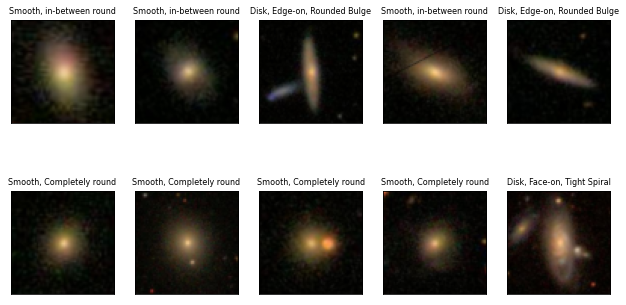

In [3]:
def plot_gallery(images, titles, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(galaxy10cls_lookup(titles[i]), size=8)
        plt.xticks(())
        plt.yticks(())
         
plot_gallery(galaxy_X, galaxy_y) 

In [4]:
import pandas as pd
from skimage.color import rgb2gray
import copy

y = copy.deepcopy(galaxy_y)
X = galaxy_X.flatten().reshape(n_samples, h*w*n_channels)
galaxy_grey = rgb2gray(galaxy_X)

X_grey = galaxy_grey.flatten().reshape(n_samples, h*w)

df = pd.DataFrame(X)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,14273,14274,14275,14276,14277,14278,14279,14280,14281,14282
0,16,18,15,18,20,15,16,17,12,13,...,1,8,11,3,11,14,6,12,15,7
1,1,3,0,1,1,1,1,1,1,1,...,0,1,3,0,2,4,1,2,4,1
2,7,10,7,2,5,2,2,5,1,2,...,5,7,7,5,3,3,2,2,2,0
3,9,10,5,6,6,3,6,6,4,6,...,2,7,9,4,12,14,9,13,15,10
4,1,3,2,1,3,2,4,6,5,5,...,0,3,5,2,4,6,3,2,4,1


#### Metric Selection

In [5]:
from tensorflow.keras import backend as K

def f1(true_output, pred_output):
    #calc recall
    true_positives = K.sum(K.round(K.clip(true_output * pred_output, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(true_output, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    #calc prec
    predicted_positives = K.sum(K.round(K.clip(pred_output, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Train/Test Split

The dataset will enter into a 80/20 stratified shuffle split to divide the data into train and test sets. This splitting technique maintains the balance, making the dataset more reproducible in the real work because the imbalances suggest that certain galaxy shapes are more common than others. 

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in sss.split(galaxy_X, y):
    X_train, X_test = galaxy_X[train_idx], galaxy_X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)



X_train shape: (17428, 69, 69, 3) , y_train shape: (17428, 10, 2)
X_test shape: (4357, 69, 69, 3) , y_test shape: (4357, 10, 2)


# Modeling

#### Data Expansion

I will use the Keras ImageDataGenerator to expand and modify the data. This is to prevent the models from overfitting to the data used in training. This is accomplished by rotating the galaxy images at each iteration, small random shifts inplace and no vertical flips. When viewing a galaxy, multiple galaxies could belong to the same category however they are both shown in different orientations, which makes the galaxies unrelated. Data expansion techniques makes it hard for the model to get confused by such.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0,
    horizontal_flip=True,
    data_format="channels_last",
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)


/Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


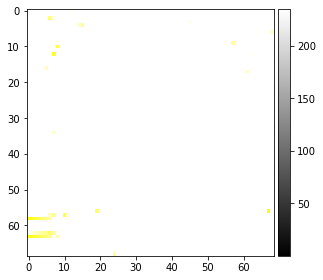

In [11]:
from skimage.io import imshow
tmps = datagen.flow(X_train, y_train, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='gray')
    break

#### CNN Variation 1

In [12]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [13]:
%%time

NUM_CLASSES = 10

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(1,8,8),
               data_format="channels_first") )

cnn.add( MaxPooling2D(pool_size=(2, 2), 
                      data_format="channels_first") )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 8)          80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 4, 4)          0         
_________________________________________________________________
activation (Activation)      (None, 16, 4, 4)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 2,650
Trainable params: 2,650
Non-trainable params: 0
______________________________________________________

In [14]:
%%time 

print(X_train.shape)
# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(17428, 69, 69, 3)


ValueError: in user code:

    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/richmondaisabor/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -3 of input shape to have value 1 but received input with shape (None, 69, 69, 3)


# Exceptional Work